<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

Basado en el [notebook de la clase 4](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_4/ejercicios/4_modelo_lenguaje_char.ipynb)

## Desafio 3

Alumno: Juan Miguel Chunga

Nota: Para este ejercicio, conviene hacer uso de GPU para acelerar el entrenamiento.

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


## Importar librerias

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos

In [ ]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

Por defecto, el libro es La vuelta al mundo en 80 dias, por lo que, se debe seleccionar otro.

Para este desafio, se opta por `El Conde de Montecristo` de [Alejandro Dumas](https://www.textos.info/alejandro-dumas/el-conde-de-montecristo).

El libro tiene 1.448 paginas y un tiempo estimado de lectura de 1 día, 18 horas, 15 minutos. Esto hace que no sea un libro tan pequeño y se obtengan resultados razonables.

In [ ]:
#https://www.textos.info/libros/mas-cortos/pag/302
#3h 44min
raw_html = urllib.request.urlopen('https://www.textos.info/abraham-valdelomar/el-caballero-carmelo-y-otros-cuentos/ebook')
#raw_html = urllib.request.urlopen('https://www.textos.info/alejandro-dumas/el-conde-de-montecristo/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [ ]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' un día, después del desayuno, cuando el sol empezaba a calentar, \nvimos aparecer, desde la reja, en el fondo de la plazoleta, un jinete en\n bellísimo caballo de paso, pañuelo al cuello que agitaba el viento, sanpedrano pellón de sedosa cabellera negra, y henchida alforja, que picaba espuelas en dirección a la casa. reconocímosle. era el hermano mayor, que años corridos, volvía. salimos atropelladamente gritando: –¡roberto, roberto! entró el viajero al empedrado patio donde el ñorbo y la campanilla \nenredábanse en las columnas como venas en un brazo y descendió en los de\n todos nosotros. ¡cómo se regocijaba mi madre! tocábalo, acariciaba su \ntostada piel, encontrábalo viejo, triste, delgado. con su ropa empolvada\n aún, roberto recorría las habitaciones rodeados de nosotros; fue a su \ncuarto, pasó al comedor, vio los objetos que se habían comprado durante \nsu ausencia, y llegó al jardín. –¿y la higuerilla? –dijo. buscaba entristecido aquel árbol cuya semilla sembrara él mismo a

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [ ]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [ ]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [ ]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

71

In [ ]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [ ]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [ ]:
tokenized_text[:1000]

[58,
 24,
 1,
 58,
 20,
 38,
 12,
 55,
 58,
 20,
 60,
 29,
 42,
 24,
 44,
 29,
 58,
 20,
 60,
 28,
 58,
 20,
 60,
 29,
 12,
 66,
 24,
 1,
 45,
 55,
 58,
 18,
 24,
 12,
 1,
 20,
 45,
 58,
 60,
 28,
 58,
 29,
 45,
 28,
 58,
 60,
 59,
 42,
 60,
 32,
 12,
 23,
 12,
 58,
 12,
 58,
 18,
 12,
 28,
 60,
 1,
 52,
 12,
 47,
 55,
 58,
 37,
 3,
 7,
 59,
 45,
 29,
 58,
 12,
 42,
 12,
 47,
 60,
 18,
 60,
 47,
 55,
 58,
 20,
 60,
 29,
 20,
 60,
 58,
 28,
 12,
 58,
 47,
 60,
 56,
 12,
 55,
 58,
 60,
 1,
 58,
 60,
 28,
 58,
 25,
 45,
 1,
 20,
 45,
 58,
 20,
 60,
 58,
 28,
 12,
 58,
 42,
 28,
 12,
 32,
 45,
 28,
 60,
 52,
 12,
 55,
 58,
 24,
 1,
 58,
 56,
 7,
 1,
 60,
 52,
 60,
 58,
 60,
 1,
 37,
 58,
 23,
 60,
 28,
 28,
 38,
 29,
 7,
 59,
 45,
 58,
 18,
 12,
 23,
 12,
 28,
 28,
 45,
 58,
 20,
 60,
 58,
 42,
 12,
 29,
 45,
 55,
 58,
 42,
 12,
 48,
 24,
 60,
 28,
 45,
 58,
 12,
 28,
 58,
 18,
 24,
 60,
 28,
 28,
 45,
 58,
 61,
 24,
 60,
 58,
 12,
 49,
 7,
 52,
 12,
 23,
 12,
 58,
 60,
 28,
 58,
 3,
 7,
 

### Organizando y estructurando el dataset

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [ ]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [ ]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [ ]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [ ]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
X.shape

(214092, 100)

In [ ]:
X[0,:10]

array([58, 24,  1, 58, 20, 38, 12, 55, 58, 20])

In [ ]:
y[0,:10]

array([24,  1, 58, 20, 38, 12, 55, 58, 20, 60])

In [ ]:
vocab_size = len(chars_vocab)

## Proponer arquitecturas de redes neuronales

- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

# Definiendo el modelo

In [ ]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense, LSTM, GRU # Se agregan los modelos LSTM y GRU
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [ ]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 71)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        54,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 71)       │        14,271 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,671 (268.25 KB)

 Trainable params: 68,671 (268.25 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

En esta etapa, se intento entrenar el modelo, pero se presento un problema por falta de GPU.

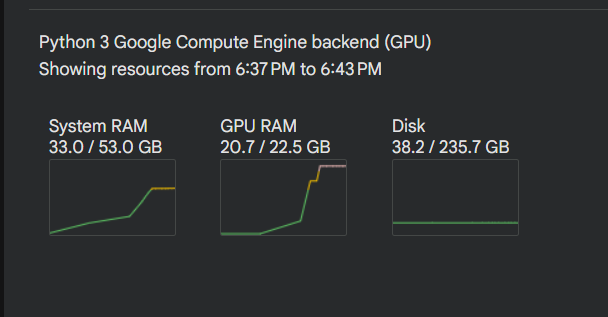

Se intentó con una GPU A100.

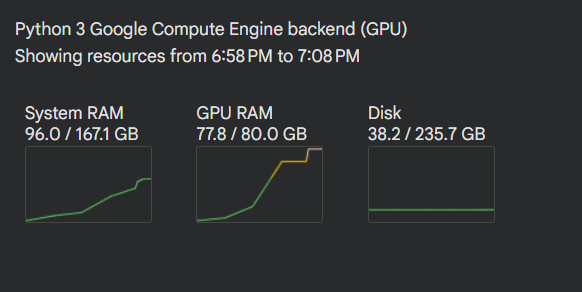

## Se disminuyo la cantidad de datos

Esto hizo que el entrenamiento fuera mas flexible, pero la notebook crasheaba constantemente, siendo necesario reiniciar la ejecución.

Se cambió de libro, lo que hizo el tiempo mas razonable, pero por limitación, esto no se concretó.

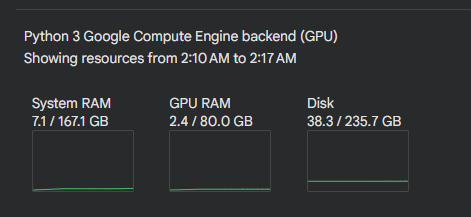

In [ ]:
history_ppl = []

num_val_subset_for_callback = 1000 # Se ajusta segun la memoria disponible
#100 - aprox 4.6 gb
#tokenized_sentences_val_subset = tokenized_sentences_val[:num_val_subset_for_callback]

hist = model.fit(
    X,
    y,
    epochs=20,
    #callbacks=[PplCallback(tokenized_sentences_val_subset, history_ppl)],#Modelo que usa un subset
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl)],#Modelo original
    batch_size=256
)

Epoch 1/20
837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.6221
 mean perplexity: 8.524303027346164 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - loss: 2.6218
Epoch 2/20
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1295
 mean perplexity: 7.498044518981805 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 2.1294
Epoch 3/20
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0104
 mean perplexity: 7.047005654387333 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 2.0103
Epoch 4/20
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9454
 mean perplexity: 6.8232244363816985 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1.9454
Epoch 5/20
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9044
 mean perplexity: 6.6340781998533735 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1.9044
Epoch 6/20
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8749
 mean perplexity: 6.47958

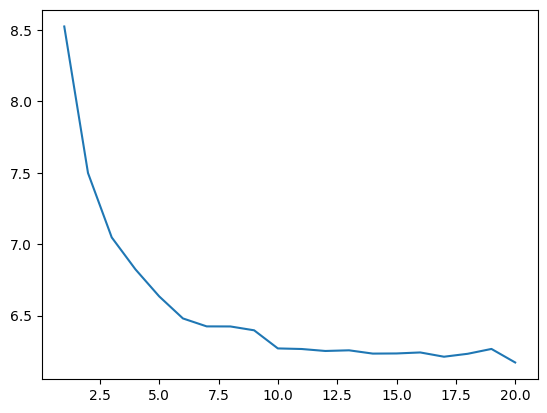

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://cd4a48eede489d14f8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://cd4a48eede489d14f8.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [ ]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habia una vez de la cara de la cara de la c'

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text.lower()]#text.lower fue agregado
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="habia una vez")

In [ ]:
salidas[0]

array([50, 12, 23,  7, 12, 58, 24,  1, 12, 58,  3, 60, 32, 58, 20, 60, 58,
       59,  7, 58, 59, 12, 20, 47, 60, 55, 58, 60,  1, 58, 60, 28, 58])

In [ ]:
# veamos las salidas
decode(salidas[0])

'habia una vez de mi madre, en el '

## Implementación de SimpleRNN (Celda de Elman)

Comenzamos definiendo el modelo

In [ ]:
model_simple_rnn = Sequential()

model_simple_rnn.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_simple_rnn.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_simple_rnn.add(Dense(vocab_size, activation='softmax'))
model_simple_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_simple_rnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 71)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 200)      │        54,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 71)       │        14,271 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,671 (268.25 KB)

 Trainable params: 68,671 (268.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        # ----------------------
        model_simple_rnn_history_ppl.append(current_score) #Se modifica para que sea compatible con el nuevo history_ppl
        # ----------------------
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


Ahora, lo entrenaremos.

In [ ]:
# Se reutilizan funciones previamente definidas
# Se modifica el numero de epocas a 50
# El callback PplCallback fue definido previamente

model_simple_rnn_history_ppl = []
#val_subset
model_simple_rnn_hist = model_simple_rnn.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val,model_simple_rnn_history_ppl)], batch_size=256)

Epoch 1/50
837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6025
 mean perplexity: 8.50334329293247 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - loss: 2.6022
Epoch 2/50
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1286
 mean perplexity: 7.523592757273324 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 2.1285
Epoch 3/50
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0113
 mean perplexity: 7.049044362100368 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 2.0112
Epoch 4/50
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9456
 mean perplexity: 6.757912643851107 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1.9456
Epoch 5/50
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9041
 mean perplexity: 6.612771123270445 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1.9041
Epoch 6/50
836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8773
 mean perplexity: 6.54049143

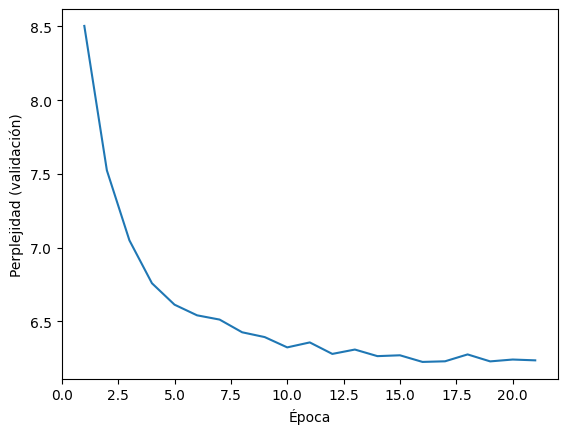

In [ ]:
# Observamos la perplejidad
import matplotlib.pyplot as plt
import seaborn as sns

# grafico del Entrenamiento
epoch_count = range(1, len(model_simple_rnn_history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=model_simple_rnn_history_ppl)
plt.xlabel("Época")
plt.ylabel("Perplejidad (validación)")
plt.show()

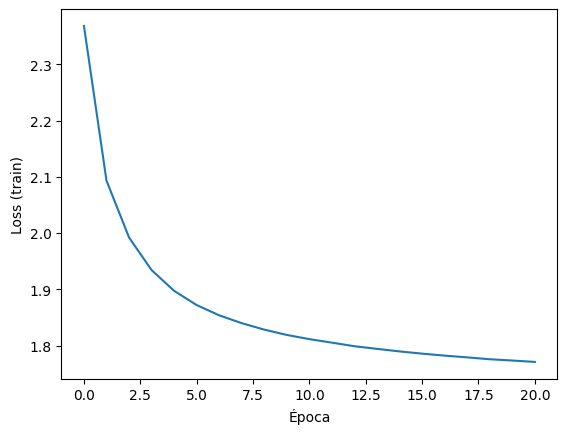

In [ ]:
# Grafica de loss
plt.plot(model_simple_rnn_hist.history["loss"])
plt.xlabel("Época")
plt.ylabel("Loss (train)")
plt.show()

In [ ]:
# Buscamos la perplejidad mas baja
min_ppl_simple_rnn=min(model_simple_rnn_history_ppl)
# Buscamos en que epoca se alcanzó
idx_rnn=model_simple_rnn_history_ppl.index(min_ppl_simple_rnn)

Cargamos el mejor modelo

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
# model_simple_rnn = keras.models.load_model('my_model.keras')

Usamos Greedy Search para generar texto

In [ ]:
# Generaremos texto usando greedy search
generate_seq(model_simple_rnn, "Edmond", max_context_size, 120)

'Edmondo en el camino de la cabeza de la cara de la cabeza de la cara de la cabeza de la cara de la cabeza de la cara de la cab'

Usamos Beam Search para generar texto

In [ ]:
# predicción con beam search
"""
Parametros:
Modo: det
Temp: 1.0
"""
salidas = beam_search(model_simple_rnn,num_beams=10,num_words=20,input="Edmond",temp=1.0, mode='det')

In [ ]:
print(salidas[0])

[60 20 59 45  1 20 45 58 60  1 58 60 28 58 18  7 60 28 45 58 20 60 58 28
 12 58]


In [ ]:
# veamos las salidas
decode(salidas[0])

'edmondo en el cielo de la '

## Implementación del modelo LSTM


In [ ]:
model_lstm = Sequential()

model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 71)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       217,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 71)       │        14,271 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,871 (905.75 KB)

 Trainable params: 231,871 (905.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        # ----------------------
        model_lstm_history_ppl.append(current_score) #Se modifica para que sea compatible con el nuevo history_ppl
        # ----------------------
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [ ]:
# Se reutilizan funciones previamente definidas
# Se modifica el numero de epocas a 50
# El callback PplCallback fue definido previamente

model_lstm_history_ppl = []
#val_subset
model_lstm_hist = model_lstm.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val,model_lstm_history_ppl)], batch_size=256)

Epoch 1/50
837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.8292
 mean perplexity: 9.927521294179344 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 188s 216ms/step - loss: 2.8288
Epoch 2/50
837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.2610
 mean perplexity: 8.757969262730724 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 179s 213ms/step - loss: 2.2609
Epoch 3/50
837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 2.1514
 mean perplexity: 8.238172234362187 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 178s 213ms/step - loss: 2.1514
Epoch 4/50
837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.0895
 mean perplexity: 7.918179769053238 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 177s 212ms/step - loss: 2.0895
Epoch 5/50
837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.0430
 mean perplexity: 7.669577174548861 

Saved new model!
837/837 ━━━━━━━━━━━━━━━━━━━━ 178s 213ms/step - loss: 2.0430
Epoch 6/50
837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.0023
 mean perpl

In [ ]:
# Observamos la perplejidad
import matplotlib.pyplot as plt
import seaborn as sns

# grafico del Entrenamiento
epoch_count = range(1, len(model_lstm_history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=model_lstm_history_ppl)
plt.xlabel("Época")
plt.ylabel("Perplejidad (validación)")
plt.show()

In [ ]:
# Grafica de loss
plt.plot(model_lstm_history_ppl.history["loss"])
plt.xlabel("Época")
plt.ylabel("Loss (train)")
plt.show()

In [ ]:
# Buscamos la perplejidad mas baja
min_ppl_simple_lstm=min(model_lstm_history_ppl)
# Buscamos en que epoca se alcanzó
idx_rnn=model_lstm_history_ppl.index(min_ppl_simple_lstm)


In [ ]:
# Generaremos texto usando greedy search
generate_seq(model_lstm, "Edmond", max_context_size, 120)

In [ ]:
# predicción con beam search
"""
Parametros:
Modo: det
Temp: 1.0
"""
salidas = beam_search(model_lstm,num_beams=10,num_words=20,input="Edmond",temp=1.0, mode='det')


In [ ]:
print(salidas[0])

In [ ]:
# veamos las salidas
decode(salidas[0])

## Conclusiones

El notebook busca demostrar las capacidades de los modelos de lenguaje a nivel de carácter utilizando diversas arquitecturas RNN para generación de texto y resalta la importancia de la perplejidad como métrica de evaluación, así como distintas estrategias de decodificación.

Por limitaciones de GPU y recursos, no se completó el experimento.